# Importing Packages

In [1]:
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc import types, fft, waveform
import lal
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams.update({'figure.autolayout': True, "text.usetex": True})
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "monospace"

import matplotlib.colors as colors
from matplotlib import gridspec
from matplotlib import ticker
import pyseobnr
from pyseobnr.generate_waveform import GenerateWaveform

plt.style.reload_library()


/home/pratul/anaconda3/envs/pyseob/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


# Importing $(l, m)=(2, 2)$ analytical model notebook 

In [2]:
# %run Model_22_Updated.ipynb   #(for SEOBNRv4 merger-ringdown attachment)
%run Model_22_Updated_v5HM.ipynb   #(for SEOBNRv5 merger-ringdown attachement)

In [3]:
def intp(t,h):   
    delta_t  = 1/4096
    #### interpolation to sample data at equispaced time points
    tVec_NR_int = np.linspace(t[0],t[-1],int(abs(t[-1]-t[0])/delta_t)) 
    hp_NR_sample = interp1d(t,h,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR_int)
    
    return(tVec_NR_int,hp_NR_int)

# Dominant mode model v/s $(2, 2)$ mode hybrids Match

# $(2, 2)$ mode EOB vs $(2, 2)$ mode hybrids Match

In [6]:
L=5


def freq(j):
    return(xlow**(3/2)/(j*MTSUN_SI*math.pi))


def loop(angle,appx):
    
    mass_array=[]
    match_array=[]
    mismatch_array=[]
    
    theta=angle
    
    L=5
    for l in range(1,L+1):
        
        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            globals()['sph' + str(l) + str(m)] = Ylm
    
    
    hpVec=(sph22*hpl2m2Vec)         
    tVec_NR=tl2m2Vec
    
    
    for i in tqdm(range(35,201,5)):    
        M1=i*q/(q+1)
        M2=i/(q+1)
        M=i
        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec_SI=tVec_NR*M*MTSUN_SI;
        hpVec_SI=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI;
        delta_t_NR=np.mean(np.diff(tVec_SI))
        
        mergIdx=np.argmax(hpVec_SI)
        tVec_SI_shifted=tVec_SI-tVec_SI[mergIdx]
        
    
        hpVec_SI = TimeSeries(hpVec_SI, delta_t=delta_t_NR, epoch=-delta_t_NR*mergIdx) 
        
        
        xmin = xconv(f,30)
        flow = fconv(xmin,i)
            
        #Turn on the next line when EOB is needed
        # hp, hc= get_td_waveform(approximant=appx,
        #                           mass1=M1,
        #                           mass2=M2,
        #                           delta_t=delta_t_NR,
        #                           f_lower=flow,
        #                           distance=1,inclination=theta)

        wfm_gen = GenerateWaveform({"mass1": M1,"mass2": M2,"spin1x": 0, "spin1y": 0, "spin1z": 0, "spin2x": 0, "spin2y": 0, 
        "spin2z": 0, "deltaT": delta_t_NR, "f22_start": flow,"distance": 1,"inclination": theta,"approximant": appx})

        times_eob, hlm_eob = wfm_gen.generate_td_modes()
        times_eob = times_eob - times_eob[np.argmax(abs(hlm_eob[(2,2)]))]
        #plt.plot(times,hlm_eob[(2,2)])
        hp = TimeSeries(np.real(hlm_eob[(2,2)]) * mode2polfac, delta_t_NR)
        hc = TimeSeries(np.imag(hlm_eob[(2,2)]) * mode2polfac, delta_t_NR)
        
        
        #Turn on the next line when dominant mode model is needed
        # hp, hc = eccmodel(M,q,e,li,flow,inclination=theta,d=1,delta_t=delta_t_NR) #edit = commented
       
    
        sp=hpVec_SI
        # Resize the waveforms to the same length
        tlen = max(len(sp), len(hp))
        sp.resize(tlen)
        hp.resize(tlen)
        
        # Generate the aLIGO ZDHP PSD
        delta_f = 1.0 / sp.duration 
        flen = tlen//2 + 1
        f_low = 20 #flow
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
        # Note: This takes a while the first time as an FFT plan is generated
        # subsequent calls are much faster.
        m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
        mismatch=1-m
    
    
        mass_array.append(M)
        match_array.append(m)
        mismatch_array.append(mismatch)
        
    return (mass_array,mismatch_array)

# List of Hybrids and Parameters 

In [11]:

# hyb = ['1355','1356','1358','1359','1360','1361','1364','1365','1366','1367','1368','1372','1373']
# # # # # # # # # # #hyb = ['1355','1356','1357','1358','1359','1360','1361','1362','1363','1364','1365','1366','1367','1368','1369','1370','1371','1372','1373','1374']
hyb = ['1357','1362','1363','1369','1370','1371','1374']
 
# q0 = [1,1,1,1,1,1,2,2,2,2,2,3,3]
# # # # # # # # # # # # #q0 = [1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3]#,1,1,2,2,2,2,2,2,2,3,3,3,3]
# # # # # # # # # # # # # # # # q0 = [1,3,3,1]#,1,1,2,2,3,3]

# l0 = [1.423,1.574,-2.682,1.834,-0.395,-1.019,-0.181,-1.127,-2.890,1.687,0.420,3.005,1.682]
# # # # # # # # # # # # #l0 = [1.423,1.574,0.451,-2.682,1.834,-0.395,-1.019,-0.507,-0.912,-0.181,-1.127,-2.890,1.687,0.420,-0.203,3.063,0.665,3.005,1.682,3.114]
# # # # # # # # # # # # # # # #l0 = [0.451,-0.507,-0.912,-0.203,3.063,0.665,3.114]
# # # # # # # # # # # # # # # # l0 = [-1.485073283630268,1.472185704752935,-0.643416777464780,0.749210028724813]

# # # # # # # # # # # # # # # #optimized
# # # # # # # # # # # # # # # l0 = [1.457698601070823,1.545926321364142,-1.141463456213547,-2.693473755619668,1.801219830098859,-0.396207652528180,-1.040413635746776,
# # # # # # # # # # # # # # #      0.555646156872561,0.724538550692518,-0.182226250109515,-1.126952905483996,-2.898083042032514,1.687112723670825,0.440881567027385,-0.670280048376114,0.315994559864006,
# # # # # # # # # # # # # # #       -0.148396202822511,3.000739904710272,1.653396161845405,-0.634051991885378]#,,
      


# e0 = [0.173, 0.230, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.300, 0.300]
# # # # # # # # # # # # #e0 = [0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.483, 0.505, 0.172, 0.209, 0.320, 0.320, 0.324, 0.478, 0.508, 0.204, 0.300, 0.300, 0.495]
# # # # # # # # # # # # # # # #e0 = [0.120,0.163,0.227,0.227,0.227,0.299,0.299,0.373,0.373,0.120,0.145,0.228,0.228,0.228,0.373,0.373,0.142,0.209,0.209,0.359]
# # # # # # # # # # # # # # # #e0 = [0.322,0.483,0.505,0.478,0.508,0.204,0.495]

# # # # # # # # # # # # # # # #optimized      
# # # # # # # # # # # # # # # e0 = [0.172926133383720,0.230179472749136,0.282642497018959,0.322052907634972,0.316240760183839,0.416002927744532,0.416367342201027
# # # # # # # # # # # # # # #       ,0.380975074882384,0.360169374404902,0.172041289449430,0.208966506340969,0.320277828274568,0.319959674985657,0.323867874652433,0.354075731889641,0.319022537509785,
# # # # # # # # # # # # # # #       0.201689318505820,0.300010161505406,0.299888037529765,0.249615033146475]#,,
      

# f0 = [16.53, 15.63, 13.51, 13.92, 12.18, 11.95, 16.68, 15.72, 13.76, 13.84, 13.36, 13.75, 13.74]
# # # #f0 = [16.53, 15.63, 13.74, 13.51, 13.92, 12.18, 11.95, 12.78, 11.62, 16.68, 15.72, 13.76, 13.84, 13.36, 12.87, 10.69, 15.94, 13.75, 13.74, 10.62]
# # # # # #f0 = [13.74]#,12.78,11.62,12.87,10.69,15.94,10.62]
# # # # # # f0 = [13.999488787680876,14.679838700028833,20.403184181926761,20.180558433369974]

# # # #optimized
# # f0 = [16.530134916533306,15.627126597061668,15.986378920335326,13.508410901716282,13.931068789064991,12.179093524614910,
# #       11.943285683368341,18.624734154311419,20.176459471658156,16.676557359364811,15.717929316907188,13.755545615346470,13.838171735947707,13.361228227238332,
# #       24.976313258966123,24.950544770380752,15.036932464176257,13.748168070054010,13.741515087939336,20.413662164525164] #,,

params_data = np.loadtxt('optimized_hybrid_params-Copy1.txt')
#hyb = params_data[:,0]
q0 = params_data[:,1]
l0 = params_data[:,2]
e0 = params_data[:,3]
f0 = params_data[:,4]



print(len(hyb),len(q0),len(l0),len(e0),len(f0))


7 7 7 7 7


In [12]:
# with open('optimized_hybrid_params.txt', 'w') as f:
#     # Iterate through the lists simultaneously using zip
#     for item1, item2, item3, item4, item5 in zip(hyb, q0, l0, e0, f0):
#         # Write each set of items separated by a tab (or any other delimiter you prefer)
#         f.write(f"{item1}\t{item2}\t{item3}\t{item4}\t{item5}\n")

# Choose Approximant and Inclination

In [13]:
appx="SEOBNRv5HM"
inc = 0
print(inc)
mode2polfac=4*(5/(64*np.pi))**(1/2)

0


# Match Calculations 

In [14]:
for i in range(0,len(hyb)):
    hname = hyb[i]
    q = q0[i]
    e = e0[i]
    li = l0[i]
    f = f0[i]
    
    #hfile = [hname+'hyb_EccTD_xlow045_GM.h5']
    # hfile = [hname+'_EccTD_Ebersold_hybrid.h5']         #for pure EccentricTD new hybs

    
    # #hf = h5py.File('/home/pratul/Downloads/Project/hybrids/'+hfile[0],'r')
    # hf=h5py.File('/home/pratul/Downloads/Project/New hybrids/Final_hybrids'+hfile[0],'r')       #for pure ecctd

    # data = hf['l2_m2']
    # tl2m2Vec = np.real(data[:,0])
    # hpl2m2Vec = np.real(data[:,1])



    hfile = [hname+'_EccTD_Ebersold_hybrid.h5']
    file_path = '/home/pratul/Downloads/Project/New hybrids/Final_hybrids/' + hfile[0]

    with h5py.File(file_path, 'r') as hf:
        # Access the dataset 'l2_m2'
        data = hf['l2_m2']
    
        # Extract real parts of the dataset
        tl2m2Vec = np.real(data[:, 0])
        hpl2m2Vec = np.real(data[:, 1])
    
    
    
    Mtot,globals()['match' + str(hname)] = loop(inc,appx)

100%|███████████████████████████████████████████| 34/34 [00:03<00:00,  8.61it/s]


In [9]:
# match1364

# Plot settings

In [15]:
# estr = [0.173, 0.230, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.300, 0.300]
estr=[0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.483, 0.505, 0.172, 0.209, 0.320, 0.320, 0.324, 0.478, 0.508, 0.204, 0.300, 0.300, 0.495]
# estr = [0.322,0.204,0.495,0.505]#,0.483,0.505,0.478,0.508,0.204,0.495]

#delete later(old check)
# estr = [0.173, 0.230, 0.322, 0.322, 0.317, 0.416, 0.416, 0.172, 0.209, 0.320, 0.320, 0.324, 0.204, 0.300, 0.300]

In [16]:
tick = np.linspace(0.15,0.42,7)  
tick = np.linspace(0.15,0.42,11)
tick = np.around(tick,decimals=2)

In [17]:
#import matplotlib.pyplot as mpl
from matplotlib.ticker import LogFormatter
from matplotlib import rc
import cmcrameri.cm as cmc

In [18]:
plt.rc('xtick', labelsize=14, direction='in') 
plt.rc('ytick', labelsize=14, direction='in') 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1

/tmp/ipykernel_15941/376876944.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick)


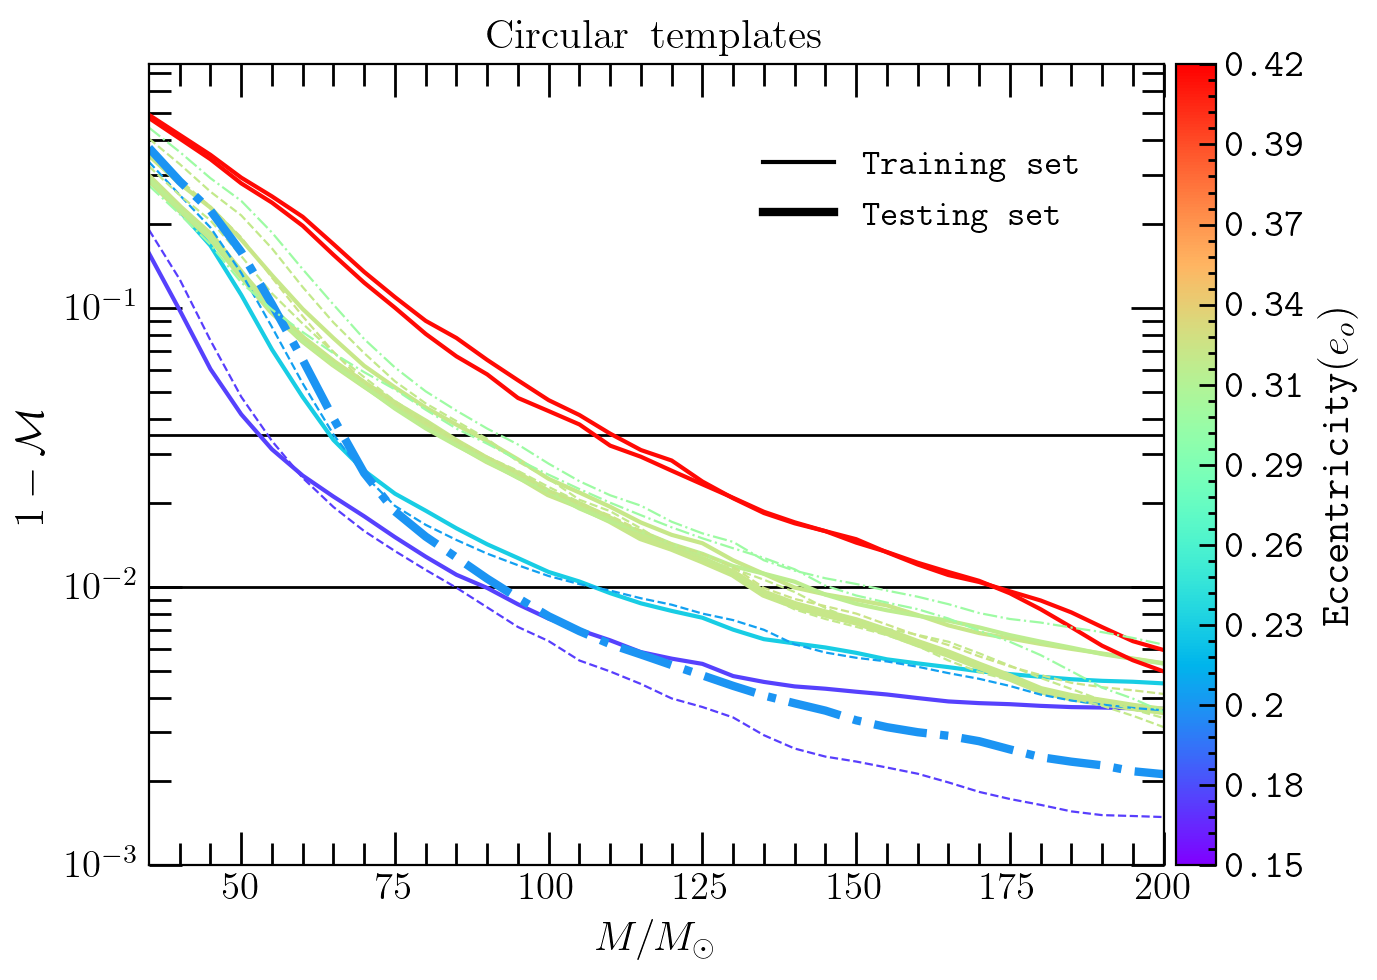

In [22]:
fig = plt.figure(figsize=(7,5)) 
binl = 0.001
N = int((0.42-0.15)/binl)

# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

cmap = plt.get_cmap('rainbow', N)
# new_cmap = truncate_colormap(cmap, 0.2, 0.9)
# cmap = new_cmap

sm = plt.cm.ScalarMappable(cmap=cmap)
#lw = [2,0.8,1,1.5,3.0] #old
lw = [1.5,0.8,3.0]

lsty=['-','--','dashdot']

plt.axhline(y = 1-0.965, color = 'k', linestyle = '-',linewidth = 1)
plt.axhline(y = 1-0.99, color = 'k', linestyle = '-',linewidth = 1)
#'''
plt.plot(Mtot,np.array(match1355),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[0]-0.15)/binl)))
plt.plot(Mtot,np.array(match1356),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[1]-0.15)/binl)))
plt.plot(Mtot,np.array(match1357),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[2]-0.15)/binl)))
plt.plot(Mtot,np.array(match1358),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[3]-0.15)/binl)))
plt.plot(Mtot,np.array(match1359),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[4]-0.15)/binl)))
plt.plot(Mtot,np.array(match1360),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[5]-0.15)/binl)))
plt.plot(Mtot,np.array(match1361),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[6]-0.15)/binl)))
#plt.plot(Mtot,np.array(match1362),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[7]-0.15)/binl)))
#plt.plot(Mtot,np.array(match1363),linestyle=lsty[0],linewidth = lw[0],c=cmap(int((estr[8]-0.15)/binl)))

plt.plot(Mtot,np.array(match1364),linestyle=lsty[1],linewidth = lw[1],c=cmap(int((estr[9]-0.15)/binl)))
plt.plot(Mtot,np.array(match1365),linestyle=lsty[1],linewidth = lw[1],c=cmap(int((estr[10]-0.15)/binl)))
plt.plot(Mtot,np.array(match1366),linestyle=lsty[1],linewidth = lw[1],c=cmap(int((estr[11]-0.15)/binl)))
plt.plot(Mtot,np.array(match1367),linestyle=lsty[1],linewidth = lw[1],c=cmap(int((estr[12]-0.15)/binl)))
plt.plot(Mtot,np.array(match1368),linestyle=lsty[1],linewidth = lw[1],c=cmap(int((estr[13]-0.15)/binl)))
#plt.plot(Mtot,np.array(match1369),linestyle=lsty[1],linewidth = lw[4],c=cmap(int((estr[14]-0.15)/binl)))
#plt.plot(Mtot,np.array(match1370),linestyle=lsty[1],linewidth = lw[4],c=cmap(int((estr[15]-0.15)/binl)))

plt.plot(Mtot,np.array(match1371),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[16]-0.15)/binl)))
plt.plot(Mtot,np.array(match1372),linestyle=lsty[2],linewidth = lw[1],c=cmap(int((estr[17]-0.15)/binl)))
plt.plot(Mtot,np.array(match1373),linestyle=lsty[2],linewidth = lw[1],c=cmap(int((estr[18]-0.15)/binl)))
#plt.plot(Mtot,np.array(match1374),linestyle=lsty[2],linewidth = lw[4],c=cmap(int((estr[19]-0.1)/binl)))





cbar = plt.colorbar(sm,pad=0.01)
cbar.minorticks_on()

tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_yticklabels(tick)
cbar.set_label(label='Eccentricity$(e_o)$',size=15)
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=3, direction = 'in', color='black')
cbar.ax.tick_params(which="major",width=1, length=6, direction = 'in', color='black')

#plt.title(r'$\iota = 0$', fontsize = 15, loc = 'center')
plt.ylim(ymax=7.5e-1)
plt.ylim(ymin=4e-4)
plt.ylim(ymin=1e-3)
plt.xlim(xmin=35)
plt.xlim(xmax=200)


plt.yscale('log')


plt.ylabel(r'$1-\mathcal{M}$',fontsize=15)
plt.xlabel(r'$M/M_\odot$',fontsize=15)
plt.title(r'$\mathrm{Circular\ templates}$', fontsize = 15, loc = 'center')



from matplotlib.lines import Line2D

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size


for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)
    x_line3 = np.linspace(x, 1.5 * x, 10)
    y_line3 = np.linspace(y**2, y**2 - x, 10)

    plt.plot(x_line1, y_line1)
    plt.plot(x_line2, y_line2)
    plt.plot(x_line3, y_line3)


lgd1 = Line2D([0], [0], color='black', linewidth=lw[0],linestyle=lsty[0])   
lgd2 = Line2D([0], [0], color='black', linewidth=lw[1],linestyle=lsty[1])  
lgd3 = Line2D([0], [0], color='black', linewidth=lw[1],linestyle=lsty[2])  
lgd4 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[0])  #addition
lgd5 = Line2D([0], [0], color='black', linewidth=lw[0],linestyle=lsty[0])  #addition
    
cmap_labels = [r"$q=1$",r"$q=2$",r"$q=3$"]
cmap_labels_2 = ["Testing set"]
cmap_handles = []
cmap_handles.append(lgd1)
cmap_handles.append(lgd2)
cmap_handles.append(lgd3)

cmap_handles_2 = []
cmap_handles_2.append(lgd4)


first_legend = plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           ncol = 1, loc=1 ,bbox_to_anchor=(0.96,0.96),prop={'size': 12.8},frameon=False)
        
second_legend = plt.legend(handles=[lgd5, lgd4], 
           labels=['Training set', 'Testing set'], 
           loc='lower right', 
           bbox_to_anchor=(0.95, 0.75), 
           prop={'size': 12.8}, 
           frameon=False)
        

# fig.add_artist(first_legend)
plt.xticks([50,75,100,125,150,175,200])

plt.minorticks_on()
plt.tick_params(axis='x',which='minor',direction='in',top=True)   
plt.tick_params(axis='y',direction='in',right=True)
plt.tick_params(axis='y',which='minor',right=True,direction='in')
plt.tick_params(axis='x',direction='in',top=True)
plt.tight_layout()
# plt.savefig('/home/pratul/Downloads/Project/Plots_draft/Model_Hyb_22_Mismatch.pdf',dpi=300)#, bbox_inches='tight')
# plt.savefig('/home/pratul/Downloads/Project/Plots_draft/EOB_Hyb_22_Mismatch.pdf',dpi=300)
#plt.savefig('/home/pratul/Downloads/Model_slides_Mismatch.pdf',dpi=300)
plt.show()

/tmp/ipykernel_14341/435654563.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick)


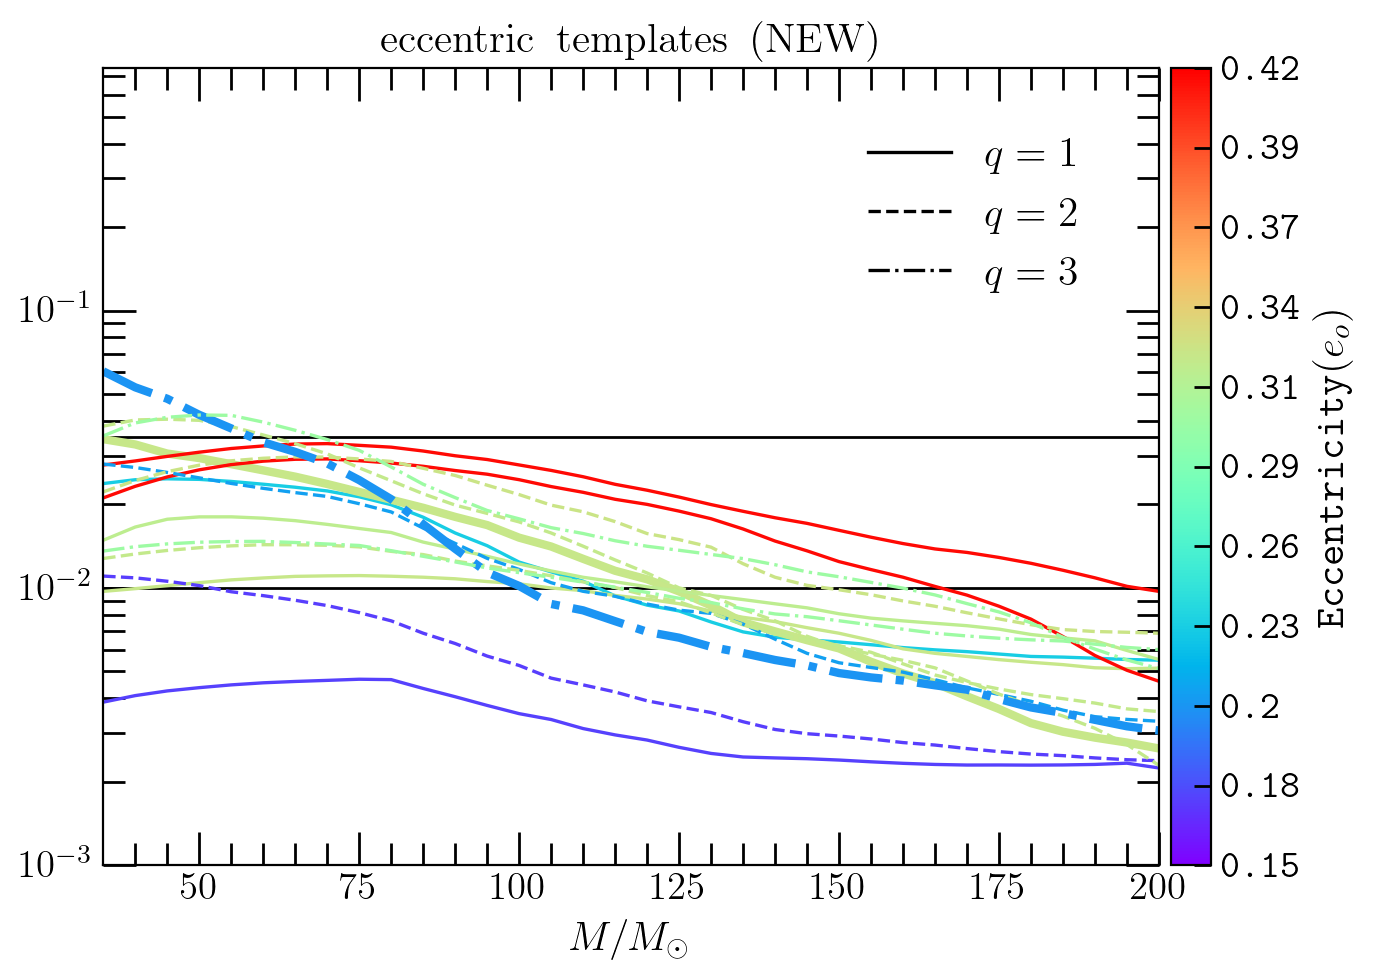

In [41]:
plt.figure(figsize=(7,5)) 
binl = 0.001
N = int((0.42-0.15)/binl)
cmap = plt.get_cmap('rainbow', N)
sm = plt.cm.ScalarMappable(cmap=cmap)
lw = [2,0.8,1.2,1.5,3.0]
lsty=['-','--','dashdot']

plt.axhline(y = 1-0.965, color = 'k', linestyle = '-',linewidth = 1)
plt.axhline(y = 1-0.99, color = 'k', linestyle = '-',linewidth = 1)
#'''
plt.plot(Mtot,np.array(match1355),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[0]-0.15)/binl)))
plt.plot(Mtot,np.array(match1356),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[1]-0.15)/binl)))
plt.plot(Mtot,np.array(match1357),linestyle=lsty[0],linewidth = lw[4],c=cmap(int((estr[2]-0.15)/binl)))
plt.plot(Mtot,np.array(match1358),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[3]-0.15)/binl)))
plt.plot(Mtot,np.array(match1359),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[4]-0.15)/binl)))
plt.plot(Mtot,np.array(match1360),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[5]-0.15)/binl)))
plt.plot(Mtot,np.array(match1361),linestyle=lsty[0],linewidth = lw[2],c=cmap(int((estr[6]-0.15)/binl)))
# plt.plot(Mtot,np.array(match1362),linestyle=lsty[0],linewidth = lw[4],c=cmap(int((estr[7]-0.1)/binl)))
# plt.plot(Mtot,np.array(match1363),linestyle=lsty[0],linewidth = lw[4],c=cmap(int((estr[8]-0.1)/binl)))

plt.plot(Mtot,np.array(match1364),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[9]-0.15)/binl)))
plt.plot(Mtot,np.array(match1365),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[10]-0.15)/binl)))
plt.plot(Mtot,np.array(match1366),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[11]-0.15)/binl)))
plt.plot(Mtot,np.array(match1367),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[12]-0.15)/binl)))
plt.plot(Mtot,np.array(match1368),linestyle=lsty[1],linewidth = lw[2],c=cmap(int((estr[13]-0.15)/binl)))
# plt.plot(Mtot,np.array(match1369),linestyle=lsty[1],linewidth = lw[4],c=cmap(int((estr[14]-0.1)/binl)))
# plt.plot(Mtot,np.array(match1370),linestyle=lsty[1],linewidth = lw[4],c=cmap(int((estr[15]-0.1)/binl)))

plt.plot(Mtot,np.array(match1371),linestyle=lsty[2],linewidth = lw[4],c=cmap(int((estr[16]-0.15)/binl)))
plt.plot(Mtot,np.array(match1372),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[17]-0.15)/binl)))
plt.plot(Mtot,np.array(match1373),linestyle=lsty[2],linewidth = lw[2],c=cmap(int((estr[18]-0.15)/binl)))
# plt.plot(Mtot,np.array(match1374),linestyle=lsty[1],linewidth = lw[4],c=cmap(int((estr[19]-0.1)/binl)))





cbar = plt.colorbar(sm,pad=0.01)
tick_locator = ticker.MaxNLocator(nbins=11)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.set_yticklabels(tick)
cbar.set_label(label='Eccentricity$(e_o)$',size=15)
cbar.ax.tick_params(labelsize=14,width=1.5, length=5)
cbar.ax.tick_params(which="minor",width=1, length=3, direction = 'in')
cbar.ax.tick_params(which="major",width=1, length=6, direction = 'in')

#plt.title(r'$\iota = 0$', fontsize = 15, loc = 'center')
plt.ylim(ymax=7.5e-1)
plt.ylim(ymin=4e-4)
plt.ylim(ymin=1e-3)
plt.xlim(xmin=35)
plt.xlim(xmax=200)

plt.yscale('log')


# plt.ylabel(r'$1-\mathcal{M}$',fontsize=15)
plt.xlabel(r'$M/M_\odot$',fontsize=15)


from matplotlib.lines import Line2D

x_array = np.linspace(10000, 10001, 1)
y_array = x_array
param_max = x_array.size


for param, (x, y) in enumerate(zip(x_array, y_array)):  
    x_line1 = np.linspace(x, 1.5 * x, 10)
    y_line1 = np.linspace(y**2, y**2 - x, 10)
    x_line2 = np.linspace(x, 1.5 * x, 10)
    y_line2 = np.linspace(y**2, y**2 - x, 10)
    x_line3 = np.linspace(x, 1.5 * x, 10)
    y_line3 = np.linspace(y**2, y**2 - x, 10)

    plt.plot(x_line1, y_line1)
    plt.plot(x_line2, y_line2)
    plt.plot(x_line3, y_line3)


lgd1 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[0])   
lgd2 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[1])  
lgd3 = Line2D([0], [0], color='black', linewidth=lw[2],linestyle=lsty[2])  
    
cmap_labels = [r"$q=1$",r"$q=2$",r"$q=3$"]
cmap_handles = []
cmap_handles.append(lgd1)
cmap_handles.append(lgd2)
cmap_handles.append(lgd3)

plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           ncol = 1, loc='upper right',bbox_to_anchor=(0.96,0.96), prop={'size': 15},frameon=False)
        
plt.xticks([50,75,100,125,150,175,200])
plt.title(r'$\mathrm{eccentric\ templates\ (NEW)}$', fontsize = 15, loc = 'center')

plt.minorticks_on()
plt.tick_params(axis='x',which='minor',direction='in',top=True)   
plt.tick_params(axis='y',direction='in',right=True)
plt.tick_params(axis='y',which='minor',right=True,direction='in')
plt.tick_params(axis='x',direction='in',top=True)
plt.tight_layout()
# plt.savefig('/home/pratul/Downloads/Project/Plots_draft/Model_Hyb_22_Mismatch.pdf',dpi=300)
#plt.savefig('/home/pratul/Downloads/Project/Plots_draft/EOB_Hyb_22_Mismatch.pdf',dpi=300)
# plt.savefig('/home/pratul/Downloads/Project/Plots_draft/OLDMODEL_NEWHybs_Mismatch.pdf',dpi=300)
plt.show()